https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

## import 

In [5]:
import pandas as pd
import numpy as np
import os
import gc
import time 
import matplotlib.pyplot as plt
%matplotlib inline 
np.random.seed(43)

In [6]:
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [7]:
DIR = "~/.kaggle/competitions/competitive-data-science-final-project/"
sales = pd.read_csv(DIR+'sales_train.csv.gz')
shops = pd.read_csv(DIR+'shops.csv')
items = pd.read_csv(DIR+'items.csv')
item_cats = pd.read_csv(DIR+'item_categories.csv')
tests = pd.read_csv(DIR+'test.csv.gz').drop("ID",axis=1)
samples = pd.read_csv(DIR+'sample_submission.csv.gz')

## EDA & preprocess data

In [5]:
from datetime import datetime as dt

In [6]:
# extract weekday
sales.date = sales.date.apply(lambda x: dt.strptime(x, '%d.%m.%Y'))
sales["weekday"] = sales.date.apply(lambda x: x.weekday())

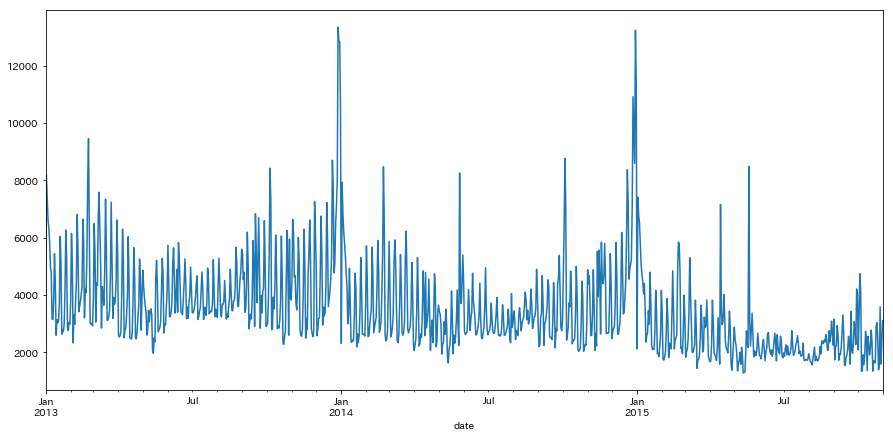

In [7]:
# the sum, variance of products are varied in each period
# This may be autoregressive
sales.groupby("date")["item_cnt_day"].sum().plot(figsize=(15,7))

In [8]:
# counts of each weekday
# On Saturday(weekday=5) & Sunday(weekday=6)  products were more sold. 
sales.groupby("weekday")["item_cnt_day"].sum()

weekday
0    401487.0
1    454985.0
2    439714.0
3    454623.0
4    553455.0
5    734648.0
6    609294.0
Name: item_cnt_day, dtype: float64

In [9]:
# 0.2% outliers
print(len(sales[sales.item_cnt_day<0]) / len(sales))

0.0025055784544777337


In [10]:
# remove roll back item
sales = sales.sort_values(["shop_id","item_id","date"]).reset_index(drop=True)
for ind in tqdm_notebook(sales[sales.item_cnt_day<0].index):
    sales_one = sales.loc[ind]
    shop_id = sales_one.shop_id
    flag=ind-1
    while(flag):
        if (sales.loc[flag].item_id != sales_one.item_id) or (sales.loc[flag].shop_id != sales_one.shop_id):
            break
        if sales.loc[flag].item_cnt_day >= -1 * sales_one.item_cnt_day:
            sales.loc[flag , "item_cnt_day"] += sales_one.item_cnt_day
            sales.loc[ind, "item_cnt_day"] = 0
            break
        flag -= 1
        
# remove other 0
sales[sales.item_cnt_day<0] = 0 

HBox(children=(IntProgress(value=0, max=7356), HTML(value='')))

In [11]:
# save preprocessed sales data
#sales.to_csv(DIR+'sales_train_processed.csv',index=None)

In [4]:
sales = pd.read_csv(DIR+'sales_train_processed.csv')

## feature engineering

In [8]:
# Create "grid" with columns
# date block num means the order of month
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop_sum':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_sum':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with shop-month aggregates: vars
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop_var':'var'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates: vars
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_var':'var'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with shop-month aggregates: max
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop_max':'max'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates: max
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_max':'max'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with shop-month aggregates: min
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop_min':'min'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates: min
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_min':'min'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with shop-month aggregates: median
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop_med':'median'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates: median
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_med':'median'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Calculate difference max - min counts
all_data['target_shop_maxmin'] = all_data['target_shop_max'] - all_data['target_shop_min'] 
all_data['target_item_maxmin'] = all_data['target_item_max'] - all_data['target_item_min'] 

# Count days in which 0 items sold in each shop, items
gb = sales[sales.item_cnt_day==0].groupby(index_cols,as_index=False).size().reset_index()
gb.columns = [col if col != 0 else 'count_zero' for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

# item price std
gb = sales.groupby(index_cols,as_index=False)['item_price'].std().reset_index(drop=True)
gb.columns = [col if col != gb.columns.values[-1] else 'price_std' for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

# item price mean
gb = sales.groupby(index_cols,as_index=False)['item_price'].mean().reset_index(drop=True)
gb.columns = [col if col != gb.columns.values[-1] else 'price_mean' for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

# mean price about last 2 digits 
all_data['price_umean'] = all_data['price_mean'] - (all_data['price_mean'] // 100) * 100

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/Users/01018569/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [9]:
# mean encoding
# these two types mean encodings are best to influcence score

cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id')['target'].cumcount()
all_data['item_target_enc'] = cumsum /cumcnt
all_data['item_target_enc'].fillna(all_data['item_target_enc'].mean(), inplace=True) 

cumsum = all_data.groupby('shop_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('shop_id')['target'].cumcount()
all_data['shop_target_enc'] = cumsum /cumcnt
all_data['shop_target_enc'].fillna(all_data['shop_target_enc'].mean(), inplace=True) 

In [10]:
# concat test data
tests["date_block_num"] = 34
tests["target"] = np.nan
tests["target_shop"] = np.nan
tests["target_item"] = np.nan
all_data = pd.concat([all_data, tests],axis=0)

In [11]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [12]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 

# We will drop these at fitting stage
# for avoid dataleakage
# to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']
#to_drop_cols = to_drop_cols + [i+'_log' for i in to_drop_cols]

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

## add tfidf features

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
# TFIDF features
tfidf_vec = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 2),
    norm='l2',
    min_df=0,
    smooth_idf=False,
    max_features=1) 

tfidf_vec.fit(shops['shop_name'].values)
shops['shop_name_tfidf'] = tfidf_vec.transform(shops['shop_name'].values)

In [15]:
shop_name_tfidf_columns = []
for ind in range(1, 20):
    shops['shop_name_tfidf_'+str(ind)] = shops['shop_name_tfidf'].apply(lambda x: x.toarray().flatten()[ind])
    shop_name_tfidf_columns.append('shop_name_tfidf_'+str(ind))

shops = shops.drop(['shop_name','shop_name_tfidf'], axis = 1)

In [16]:
all_data = pd.merge(all_data, shops, on='shop_id')

In [17]:
all_data.head()

,count_zero,date_block_num,item_id,item_target_enc,price_mean,price_std,price_umean,shop_id,shop_target_enc,target,target_item,target_item_max,target_item_maxmin,target_item_med,target_item_min,target_item_sum,target_item_var,target_shop,target_shop_max,target_shop_maxmin,target_shop_med,target_shop_min,target_shop_sum,target_shop_var,count_zero_lag_1,...,target_shop_maxmin_lag_4,target_shop_med_lag_4,target_shop_min_lag_4,target_shop_sum_lag_4,target_shop_var_lag_4,item_category_id,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19
0,0.0,12,10297,0.483516,749.0,0.0,49.0,54,0.978408,4.0,0.0,1.0,0.0,1.0,1.0,23.0,0.000000,0.0,67.0,69.0,1.0,-2.0,8198.0,3.460593,0.0,...,0.0,0.0,0.0,0.0,0.00000,37,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,12,10296,0.521739,1599.0,0.0,99.0,54,0.978438,3.0,0.0,1.0,0.0,1.0,1.0,17.0,0.000000,0.0,67.0,69.0,1.0,-2.0,8198.0,3.460593,0.0,...,0.0,0.0,0.0,0.0,0.00000,38,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,12,10298,13.299270,399.0,0.0,99.0,54,0.978459,14.0,0.0,5.0,6.0,1.0,-1.0,182.0,0.306595,0.0,67.0,69.0,1.0,-2.0,8198.0,3.460593,0.0,...,0.0,0.0,0.0,0.0,0.00000,40,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,12,10300,3.416058,699.0,0.0,99.0,54,0.978591,3.0,0.0,2.0,3.0,1.0,-1.0,26.0,0.190883,0.0,67.0,69.0,1.0,-2.0,8198.0,3.460593,0.0,...,0.0,0.0,0.0,0.0,0.00000,37,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,12,10284,0.133772,299.0,0.0,99.0,54,0.978612,1.0,0.0,1.0,0.0,1.0,1.0,3.0,0.000000,0.0,67.0,69.0,1.0,-2.0,8198.0,3.460593,0.0,...,152.0,1.0,-1.0,7827.0,10.65337,57,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
#  weekday features
#  skip this features
wdf = sales.groupby(["date", "date_block_num", "weekday"]).count().reset_index()[["date", 
                                                                            "date_block_num", "weekday"]].groupby(["date_block_num","weekday"]).size().reset_index()
submit_time = pd.DataFrame([dt(2015, 11, i) for i in range(1,31)],columns=["dt"])
submit_time["weekday"] = submit_time.dt.apply(lambda x: x.weekday())
submit_time["date_block_num"] = 34
submit_time = submit_time.groupby(["date_block_num","weekday"]).size().reset_index()
wdf = pd.concat([wdf,submit_time],axis=0)

dummy_wdf = pd.get_dummies(wdf["weekday"])
dummy_wdf.columns=["weekday_"+str(i) for i in range(7)]
dummy_wdf = dummy_wdf*np.tile(wdf[0].values.reshape(-1, 1),7)
wdf = pd.concat([wdf,dummy_wdf],axis=1).drop(["weekday", 0], axis=1).groupby("date_block_num").sum().reset_index()

all_data = pd.merge(all_data, wdf, on='date_block_num',how="left")

In [ ]:
# lag rate value
# skip this features
lag_rate_columns = [
    'item_target_enc_lag',
    'shop_target_enc_lag',
    'target_lag',
    'target_item_lag',
    'target_item_sum_lag',
    'target_item_var_lag',
    'target_shop_lag',
    'target_shop_sum_lag',
    'target_shop_var_lag',
]

for line in lag_rate_columns:
    all_data[line+'_rate12'] = all_data[line+'_1'] / (all_data[line+'_2']+10e5)
    all_data.loc[all_data[all_data[line+'_rate12']>10e3].index, line+'_rate12'] = 0

In [14]:
all_data = downcast_dtypes(all_data)

## Data Standard

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
value_cols = all_data.drop(list(set(to_drop_cols)|set(index_cols)), axis=1).columns

In [20]:
sc = StandardScaler()
all_data[value_cols] = sc.fit_transform(all_data[value_cols])

In [21]:
all_data = downcast_dtypes(all_data)

## Split train & test data

In [22]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max() # for validation data: last block is test data to predict
print('Test `date_block_num` is %d' % last_block)

test_rate = 0.25
train_rate = 1 - test_rate
dates_train = dates[dates <  (last_block - 2)]
dates_val = dates[dates == (last_block - 2)]
dates_test = dates[dates == (last_block - 1)]
dates_submit  = dates[dates == last_block]

X_train = all_data.loc[dates <  (last_block - 2)].drop(to_drop_cols, axis=1)
X_val = all_data.loc[dates == (last_block - 2)].drop(to_drop_cols, axis=1)
X_test = all_data.loc[dates == (last_block - 1)].drop(to_drop_cols, axis=1)
X_train_submit = all_data.loc[dates < last_block].drop(to_drop_cols, axis=1)
X_submit =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  (last_block - 2), 'target'].values
y_val = all_data.loc[dates == (last_block - 2), 'target'].values
y_test = all_data.loc[dates == (last_block - 1), 'target'].values
y_train_submit = all_data.loc[dates < last_block, 'target'].values
y_submit =  all_data.loc[dates == last_block, 'target'].values

Test `date_block_num` is 34


## build model of LGBM

In [23]:
# The feature extraction is "not" useful in prediction
# So, I use all features the prediction models

gbm_reg = lgb.LGBMRegressor()
gbm_reg.fit(X_train, y_train)

# print feature importance rate
features = gbm_reg.feature_importances_
selected = []
features_ind  = np.argsort(features)[::-1]

print('Feature Importances:')
for i, feat in enumerate(X_submit.columns):
    print('\t{0:10s} : {1:>.2f}'.format(feat, features[features_ind[i]]))
    if features[i]>=0: # use all features
        selected.append(feat)

Feature Importances:
	item_id    : 0.21
	shop_id    : 0.10
	count_zero_lag_1 : 0.05
	item_target_enc_lag_1 : 0.04
	price_mean_lag_1 : 0.04
	price_std_lag_1 : 0.04
	price_umean_lag_1 : 0.03
	shop_target_enc_lag_1 : 0.03
	target_lag_1 : 0.03
	target_item_lag_1 : 0.03
	target_item_max_lag_1 : 0.03
	target_item_maxmin_lag_1 : 0.03
	target_item_med_lag_1 : 0.02
	target_item_min_lag_1 : 0.02
	target_item_sum_lag_1 : 0.02
	target_item_var_lag_1 : 0.02
	target_shop_lag_1 : 0.02
	target_shop_max_lag_1 : 0.02
	target_shop_maxmin_lag_1 : 0.01
	target_shop_med_lag_1 : 0.01
	target_shop_min_lag_1 : 0.01
	target_shop_sum_lag_1 : 0.01
	target_shop_var_lag_1 : 0.01
	count_zero_lag_2 : 0.01
	item_target_enc_lag_2 : 0.01
	price_mean_lag_2 : 0.01
	price_std_lag_2 : 0.01
	price_umean_lag_2 : 0.01
	shop_target_enc_lag_2 : 0.01
	target_lag_2 : 0.01
	target_item_lag_2 : 0.01
	target_item_max_lag_2 : 0.01
	target_item_maxmin_lag_2 : 0.01
	target_item_med_lag_2 : 0.01
	target_item_min_lag_2 : 0.01
	target_item

In [24]:
# Parameter tuning
# I tried Grid Search in each hyper parameter and decide it roughtly
# I finally tune by hand about learning_rate & num_boost_round
lgb_params = {
               'max_depth': 10,
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 150, 
               'bagging_fraction': 0.5, 
               'learning_rate': 0.015, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**8,
               'bagging_freq':1,
               'lambda_l2':1,    
               'verbose':0
              }

lgb_train = lgb.Dataset(X_train[selected], y_train)
lgb_eval = lgb.Dataset(X_val[selected], y_val, reference=lgb_train)

start = time.time()
model = lgb.train(lgb_params,
            lgb_train,
            num_boost_round=200,
            valid_sets=lgb_eval,
            early_stopping_rounds=10,
            )
end = time.time()
elapsed_time = end - start
print ("train elapsed_time:{0}".format(elapsed_time) + "[sec]")

start = time.time()
pred = model.predict(X_val[selected], num_iteration=model.best_iteration)
end = time.time()
elapsed_time = end - start
print ("prediction elapsed_time:{0}".format(elapsed_time) + "[sec]")

# Check the score 
# To avoid over fitting, I seperate two datasets valid & test
# For competition rule, I clip y  between [0, 20]
print('Test R-squared for LightGBM is %f' % r2_score(y_val.clip(0,20), pred.clip(0,20)))
print('Valid RMSE is %f' % np.sqrt(mean_squared_error(y_val.clip(0,20), pred.clip(0,20))))
print('Test RMSE is %f' % np.sqrt(mean_squared_error(y_test.clip(0,20), 
                                                     model.predict(X_test[selected], num_iteration=model.best_iteration).clip(0,20))))

[1]	valid_0's rmse: 6.83566
Train until valid scores didn't improve in 10 rounds.
[2]	valid_0's rmse: 6.8238
[3]	valid_0's rmse: 6.81254
[4]	valid_0's rmse: 6.8016
[5]	valid_0's rmse: 6.79095
[6]	valid_0's rmse: 6.78049
[7]	valid_0's rmse: 6.77142
[8]	valid_0's rmse: 6.76598
[9]	valid_0's rmse: 6.75587
[10]	valid_0's rmse: 6.74767
[11]	valid_0's rmse: 6.73781
[12]	valid_0's rmse: 6.72849
[13]	valid_0's rmse: 6.7227
[14]	valid_0's rmse: 6.71681
[15]	valid_0's rmse: 6.70689
[16]	valid_0's rmse: 6.69895
[17]	valid_0's rmse: 6.69007
[18]	valid_0's rmse: 6.6835
[19]	valid_0's rmse: 6.67782
[20]	valid_0's rmse: 6.67004
[21]	valid_0's rmse: 6.66386
[22]	valid_0's rmse: 6.65577
[23]	valid_0's rmse: 6.64782
[24]	valid_0's rmse: 6.64141
[25]	valid_0's rmse: 6.6351
[26]	valid_0's rmse: 6.62755
[27]	valid_0's rmse: 6.61981
[28]	valid_0's rmse: 6.61271
[29]	valid_0's rmse: 6.60841
[30]	valid_0's rmse: 6.60395
[31]	valid_0's rmse: 6.59841
[32]	valid_0's rmse: 6.59511
[33]	valid_0's rmse: 6.59114
[34

## Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_train[selected].values[:,2:20], y_train)
pred_lr = lr.predict(X_val[selected].values[:,2:20])

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))
print('Valid RMSE is %f' % np.sqrt(mean_squared_error(y_val.clip(0,20), pred_lr.clip(0,20))))
print('Test RMSE is %f' % np.sqrt(mean_squared_error(y_test.clip(0,20), 
                                                     lr.predict(X_test[selected].values[:,2:20]).clip(0,20))))

## ensemble

In [ ]:
alphas_to_try = np.linspace(0, 1, 1001)

l2_mix = 0
l2_alpha = 0
for alpha in tqdm_notebook(alphas_to_try):
    pred_mix = alpha * pred + (1 - alpha) * pred_lr
    score = np.sqrt(mean_squared_error(y_val.clip(0,20), pred_mix.clip(0,20)))
    if (score < l2_mix):
        l2_mix = score
        l2_alpha = alpha

# YOUR CODE GOES HERE
best_alpha = l2_alpha
l2_train_simple_mix = l2_mix

print('Best alpha: %f; Corresponding l2 score on train: %f' % (best_alpha, l2_train_simple_mix))

In [ ]:
start = time.time()
test_preds = best_alpha * model.predict(X_test) + (1 - best_alpha) * lr.predict(X_test)
end = time.time()
elapsed_time = end - start
print ("prediction elapsed_time:{0}".format(elapsed_time) + "[sec]")
print('Test RMSE is %f' % np.sqrt(mean_squared_error(y_test.clip(0,20),test_preds.clip(0,20))))

## save model

In [ ]:
import pickle

In [ ]:
pickle.dump(model, open('LGBM.model', 'wb'))
pickle.dump(lr, open('lr.model', 'wb'))

## make submit data

In [ ]:
# transform submission form
start = time.time()
submit_preds = best_alpha * model.predict(X_submit) + (1 - best_alpha) * lr.predict(X_submit)
end = time.time()
elapsed_time = end - start
print ("prediction elapsed_time:{0}".format(elapsed_time) + "[sec]")

submit_cols = ["ID", "item_cnt_month"]
submit = pd.DataFrame(np.c_[np.arange(len(submit_preds)),submit_preds.clip(0.,20.)], columns=submit_cols)
submit.ID=submit.ID.astype("int")
submit.to_csv("csv/quick_lightgbm.csv",index=None)

## simpler model

In [38]:
# 8 features
# train for all models
lgb_train = lgb.Dataset(X_train[selected[:8]], y_train)
lgb_eval = lgb.Dataset(X_val[selected[:8]], y_val, reference=lgb_train)

start = time.time()
model = lgb.train(lgb_params,
            lgb_train,
            num_boost_round=200,
            valid_sets=lgb_eval,
            early_stopping_rounds=10,
            )
end = time.time()
elapsed_time = end - start
print ("train elapsed_time:{0}".format(elapsed_time) + "[sec]")

start = time.time()
pred = model.predict(X_val[selected], num_iteration=model.best_iteration)
end = time.time()
elapsed_time = end - start
print ("prediction elapsed_time:{0}".format(elapsed_time) + "[sec]")

print('Test R-squared for LightGBM is %f' % r2_score(y_val.clip(0,20), pred.clip(0,20)))
print('Valid RMSE is %f' % np.sqrt(mean_squared_error(y_val.clip(0,20), pred.clip(0,20))))
print('Test RMSE is %f' % np.sqrt(mean_squared_error(y_test.clip(0,20), 
                                                     model.predict(X_test[selected[:8]], num_iteration=model.best_iteration).clip(0,20))))

[1]	valid_0's rmse: 6.84221
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 6.83776
[3]	valid_0's rmse: 6.83354
[4]	valid_0's rmse: 6.82957
[5]	valid_0's rmse: 6.82536
[6]	valid_0's rmse: 6.82074
[7]	valid_0's rmse: 6.81521
[8]	valid_0's rmse: 6.81034
[9]	valid_0's rmse: 6.80554
[10]	valid_0's rmse: 6.80119
[11]	valid_0's rmse: 6.79549
[12]	valid_0's rmse: 6.79139
[13]	valid_0's rmse: 6.787
[14]	valid_0's rmse: 6.78323
[15]	valid_0's rmse: 6.77955
[16]	valid_0's rmse: 6.77678
[17]	valid_0's rmse: 6.77315
[18]	valid_0's rmse: 6.77017
[19]	valid_0's rmse: 6.76768
[20]	valid_0's rmse: 6.76415
[21]	valid_0's rmse: 6.76118
[22]	valid_0's rmse: 6.75796
[23]	valid_0's rmse: 6.75345
[24]	valid_0's rmse: 6.75108
[25]	valid_0's rmse: 6.74762
[26]	valid_0's rmse: 6.74427
[27]	valid_0's rmse: 6.74113
[28]	valid_0's rmse: 6.73921
[29]	valid_0's rmse: 6.73625
[30]	valid_0's rmse: 6.73349
[31]	valid_0's rmse: 6.73136
[32]	valid_0's rmse: 6.72951
[33]	valid_0's rmse: 

In [39]:
# 10 features
# train for all models
lgb_train = lgb.Dataset(X_train[selected[:10]], y_train)
lgb_eval = lgb.Dataset(X_val[selected[:10]], y_val, reference=lgb_train)

start = time.time()
model = lgb.train(lgb_params,
            lgb_train,
            num_boost_round=200,
            valid_sets=lgb_eval,
            early_stopping_rounds=10,
            )
end = time.time()
elapsed_time = end - start
print ("train elapsed_time:{0}".format(elapsed_time) + "[sec]")

start = time.time()
pred = model.predict(X_val[selected], num_iteration=model.best_iteration)
end = time.time()
elapsed_time = end - start
print ("prediction elapsed_time:{0}".format(elapsed_time) + "[sec]")

print('Test R-squared for LightGBM is %f' % r2_score(y_val.clip(0,20), pred.clip(0,20)))
print('Valid RMSE is %f' % np.sqrt(mean_squared_error(y_val.clip(0,20), pred.clip(0,20))))
print('Test RMSE is %f' % np.sqrt(mean_squared_error(y_test.clip(0,20), 
                                                     model.predict(X_test[selected[:10]], num_iteration=model.best_iteration).clip(0,20))))

[1]	valid_0's rmse: 6.83656
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 6.82498
[3]	valid_0's rmse: 6.81434
[4]	valid_0's rmse: 6.80325
[5]	valid_0's rmse: 6.793
[6]	valid_0's rmse: 6.78344
[7]	valid_0's rmse: 6.77824
[8]	valid_0's rmse: 6.76841
[9]	valid_0's rmse: 6.7636
[10]	valid_0's rmse: 6.75431
[11]	valid_0's rmse: 6.7495
[12]	valid_0's rmse: 6.7416
[13]	valid_0's rmse: 6.73214
[14]	valid_0's rmse: 6.72533
[15]	valid_0's rmse: 6.7167
[16]	valid_0's rmse: 6.70871
[17]	valid_0's rmse: 6.70094
[18]	valid_0's rmse: 6.69244
[19]	valid_0's rmse: 6.68844
[20]	valid_0's rmse: 6.6805
[21]	valid_0's rmse: 6.67751
[22]	valid_0's rmse: 6.67039
[23]	valid_0's rmse: 6.66246
[24]	valid_0's rmse: 6.65519
[25]	valid_0's rmse: 6.64813
[26]	valid_0's rmse: 6.64561
[27]	valid_0's rmse: 6.63878
[28]	valid_0's rmse: 6.63272
[29]	valid_0's rmse: 6.62613
[30]	valid_0's rmse: 6.61983
[31]	valid_0's rmse: 6.61673
[32]	valid_0's rmse: 6.61041
[33]	valid_0's rmse: 6.607